In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Step 1: Load the dataset
data = pd.read_csv('/content/emotions.csv')

In [ ]:
# Inspect the data
print(data.info())  # Gives an overview of the data, including non-null counts
print(data.describe())  # Statistical summary of the data
print(data.head())  # First few rows of the dataset


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2132 entries, 0 to 2131
Columns: 2549 entries, # mean_0_a to label
dtypes: float64(2548), object(1)
memory usage: 41.5+ MB
None
        # mean_0_a     mean_1_a     mean_2_a     mean_3_a     mean_4_a  \
count  2132.000000  2132.000000  2132.000000  2132.000000  2132.000000   
mean     15.256914    27.012462  -104.975629    13.605898    24.150483   
std      15.284621     9.265141   206.271960    16.874676    14.187340   
min     -61.300000  -114.000000  -970.000000  -137.000000  -217.000000   
25%       6.577500    26.075000  -195.000000     4.857500    23.600000   
50%      14.100000    30.000000    14.950000    15.400000    25.200000   
75%      27.700000    31.400000    29.600000    26.500000    26.800000   
max     304.000000    42.300000   661.000000   206.000000   213.000000   

        mean_d_0_a   mean_d_1_a   mean_d_2_a   mean_d_3_a   mean_d_4_a  ...  \
count  2132.000000  2132.000000  2132.000000  2132.000000  2132.000000  ... 

In [ ]:
# Check for missing values
print(data.isnull().sum())  # Sum of missing values for each column

# mean_0_a    0
mean_1_a      0
mean_2_a      0
mean_3_a      0
mean_4_a      0
             ..
fft_746_b     0
fft_747_b     0
fft_748_b     0
fft_749_b     0
label         0
Length: 2549, dtype: int64


In [ ]:
# Separate the features and the target variable
features = data.drop('label', axis=1)
labels = data['label']

# Check for missing values in features
print(features.isnull().sum())

# If there are missing values in the features, fill them with the mean of the column
features.fillna(features.mean(), inplace=True)

# Verify that there are no more missing values in the features
print(features.isnull().sum())

# Combine features and labels back together if needed, or proceed with the next steps
data = pd.concat([features, labels], axis=1)


# mean_0_a    0
mean_1_a      0
mean_2_a      0
mean_3_a      0
mean_4_a      0
             ..
fft_745_b     0
fft_746_b     0
fft_747_b     0
fft_748_b     0
fft_749_b     0
Length: 2548, dtype: int64
# mean_0_a    0
mean_1_a      0
mean_2_a      0
mean_3_a      0
mean_4_a      0
             ..
fft_745_b     0
fft_746_b     0
fft_747_b     0
fft_748_b     0
fft_749_b     0
Length: 2548, dtype: int64


In [ ]:
# Encode the target labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)  # Convert categorical labels to numeric

# One-hot encode the labels if there are multiple classes
labels = tf.keras.utils.to_categorical(labels)

# Check the shape of the labels after encoding
print(f'Shape of labels after encoding: {labels.shape}')  # Should be (samples, num_classes)


Shape of labels after encoding: (2132, 3)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Apply StandardScaler to the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Check the shape after scaling
print(f'Shape of features after scaling: {features_scaled.shape}')  # Should be (samples, features)


Shape of features after scaling: (2132, 2548)


In [ ]:
# Reshape features for GRU input
features_reshaped = features_scaled.reshape(features_scaled.shape[0], 1, features_scaled.shape[1])

# Check the shape after reshaping
print(f'Shape of features after reshaping: {features_reshaped.shape}')  # Should be (samples, timesteps, features)


Shape of features after reshaping: (2132, 1, 2548)


In [ ]:
from sklearn.model_selection import train_test_split

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(features_reshaped, labels, test_size=0.2, random_state=42)

# Verify the split
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_test: {y_test.shape}')


Shape of X_train: (1705, 1, 2548)
Shape of X_test: (427, 1, 2548)
Shape of y_train: (1705, 3)
Shape of y_test: (427, 3)


In [ ]:
def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(GRU(units=256, return_sequences=True, activation='tanh', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.4))
    model.add(GRU(units=128, activation='tanh', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.4))
    model.add(Dense(units=num_classes, activation='softmax'))  # For multi-class classification

    optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the model
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = y_train.shape[1]
model = create_model(input_shape, num_classes)

# Train the model using cross-validation or directly
history = model.fit(X_train, y_train, epochs=140, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Save the model
model.save('final_gru_model.h5')


Epoch 1/140
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.7740 - loss: 10.5240 - val_accuracy: 0.9326 - val_loss: 2.2929
Epoch 2/140
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9238 - loss: 1.7810 - val_accuracy: 0.9326 - val_loss: 0.8888
Epoch 3/140
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.9297 - loss: 0.7857 - val_accuracy: 0.9267 - val_loss: 0.6645
Epoch 4/140
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9369 - loss: 0.6024 - val_accuracy: 0.9413 - val_loss: 0.5015
Epoch 5/140
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9249 - loss: 0.5270 - val_accuracy: 0.9384 - val_loss: 0.5010
Epoch 6/140
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9311 - loss: 0.4854 - val_accuracy: 0.9267 - val_loss: 0.4816
Epoch 7/140
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9245 - loss: 0.4667 - val_accuracy: 0.9296 - val_loss: 0.4140
Epoch 8/140
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9417 - loss: 0.4101 - val_accuracy: 0

Test Accuracy: 96.25%


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

# Optional: Detailed classification report
print(classification_report(y_true, y_pred_classes))


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step
[[142   0   1]
 [  1 143   4]
 [ 10   0 126]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       143
           1       1.00      0.97      0.98       148
           2       0.96      0.93      0.94       136

    accuracy                           0.96       427
   macro avg       0.96      0.96      0.96       427
weighted avg       0.96      0.96      0.96       427



In [ ]:
import pandas as pd

# Map numerical labels back to original text labels
label_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
y_pred_classes_text = [label_mapping[label] for label in y_pred_classes]
y_true_text = [label_mapping[label] for label in y_true]

# Create a DataFrame to organize the results
results_df = pd.DataFrame({
    "Sample Index": range(1, 6),
    "Predicted Label": y_pred_classes_text[:5],
    "Actual Label": y_true_text[:5]
})

# Optionally, include some of the input features in the report for context
# Reshape X_test back to 2D for display purposes
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[2])

# Include the first few features (adjust the range for the number of features to display)
features_df = pd.DataFrame(X_test_reshaped[:5, :10], columns=[f"Feature_{i}" for i in range(1, 11)])

# Combine the results with the features
final_results = pd.concat([results_df, features_df], axis=1)

# Display the results in a clear format for the report
print("Displaying 5 Test Results with Features:")
print(final_results.to_string(index=False))


Displaying 5 Test Results with Features:
 Sample Index Predicted Label Actual Label  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  Feature_7  Feature_8  Feature_9  Feature_10
            1         NEUTRAL      NEUTRAL   1.004061   0.667987   0.658390   0.829491   0.066943  -0.128236   0.025592   0.053881  -0.038386    0.206352
            2         NEUTRAL      NEUTRAL   0.905900   0.462869   0.667119   0.805781  -0.067011  -0.139917  -0.008285  -0.044235  -0.175043   -0.029558
            3        NEGATIVE     NEGATIVE  -0.721608   0.354912  -1.125111  -0.148535   0.095144   1.544959   0.646245   0.450896  -0.304409    0.207936
            4        NEGATIVE     NEGATIVE  -0.252399   0.516847  -0.131044  -0.101116   0.299599   0.329000  -0.345859   0.057993   0.535293   -0.158131
            5        POSITIVE     POSITIVE  -1.868781  -4.405981   0.576441  -2.264628  -3.458153   0.273375   0.543978  -0.092118   0.133083    0.186807


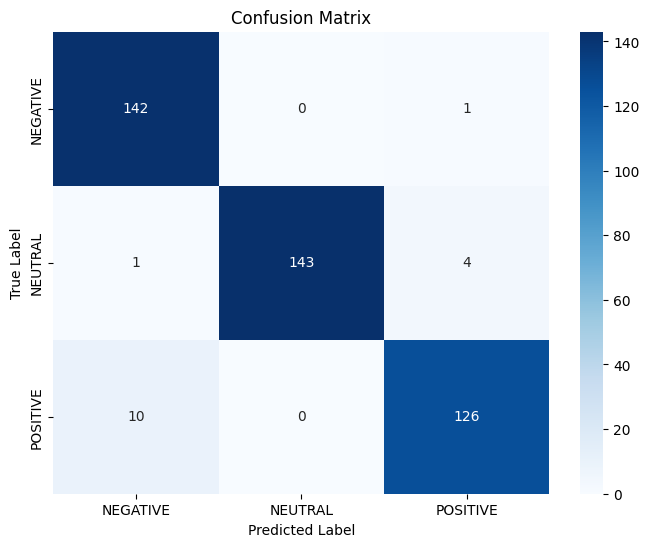

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


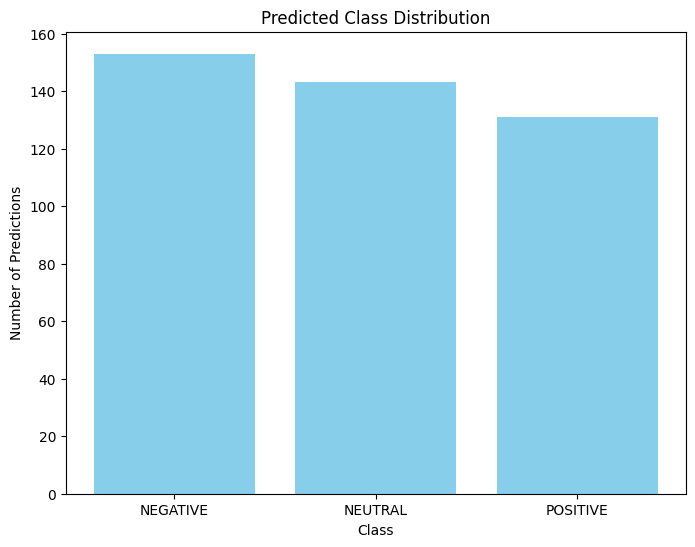

In [ ]:
# Count the number of occurrences of each predicted class
unique, counts = np.unique(y_pred_classes, return_counts=True)

# Plot a bar chart
plt.figure(figsize=(8, 6))
plt.bar(label_encoder.classes_, counts, color='skyblue')
plt.title('Predicted Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Predictions')
plt.show()


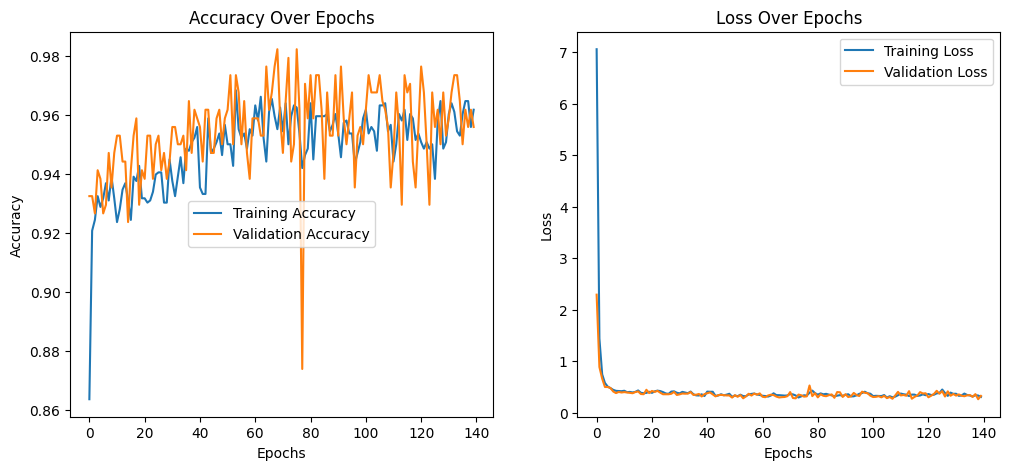

In [ ]:
# Assuming 'history' is the object returned by model.fit
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


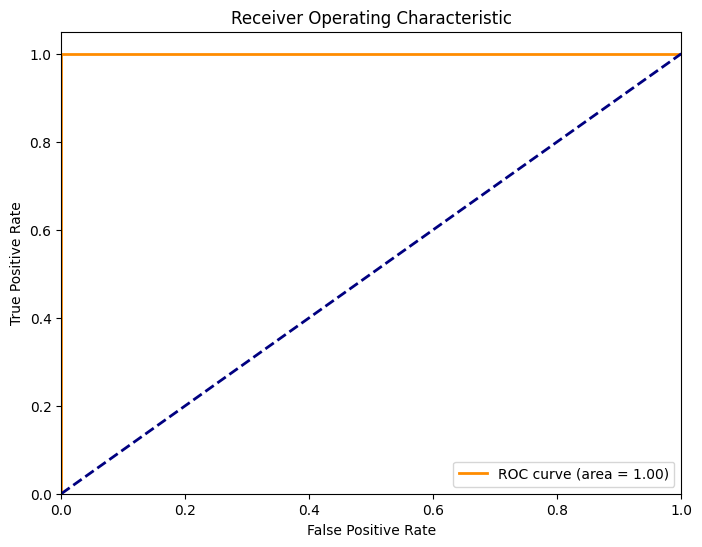

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test[:, 1], y_pred[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


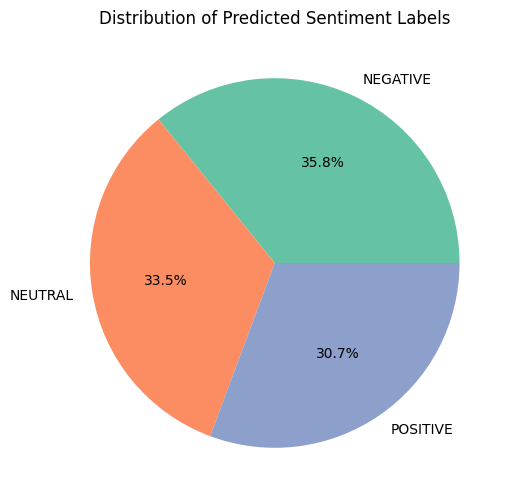

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predictions from one-hot encoded to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Map numerical predictions back to original text labels
label_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
y_pred_labels = [label_mapping[label] for label in y_pred_classes]

# Count the occurrences of each label
labels, counts = np.unique(y_pred_labels, return_counts=True)

# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=sns.color_palette("Set2"))
plt.title('Distribution of Predicted Sentiment Labels')
plt.show()


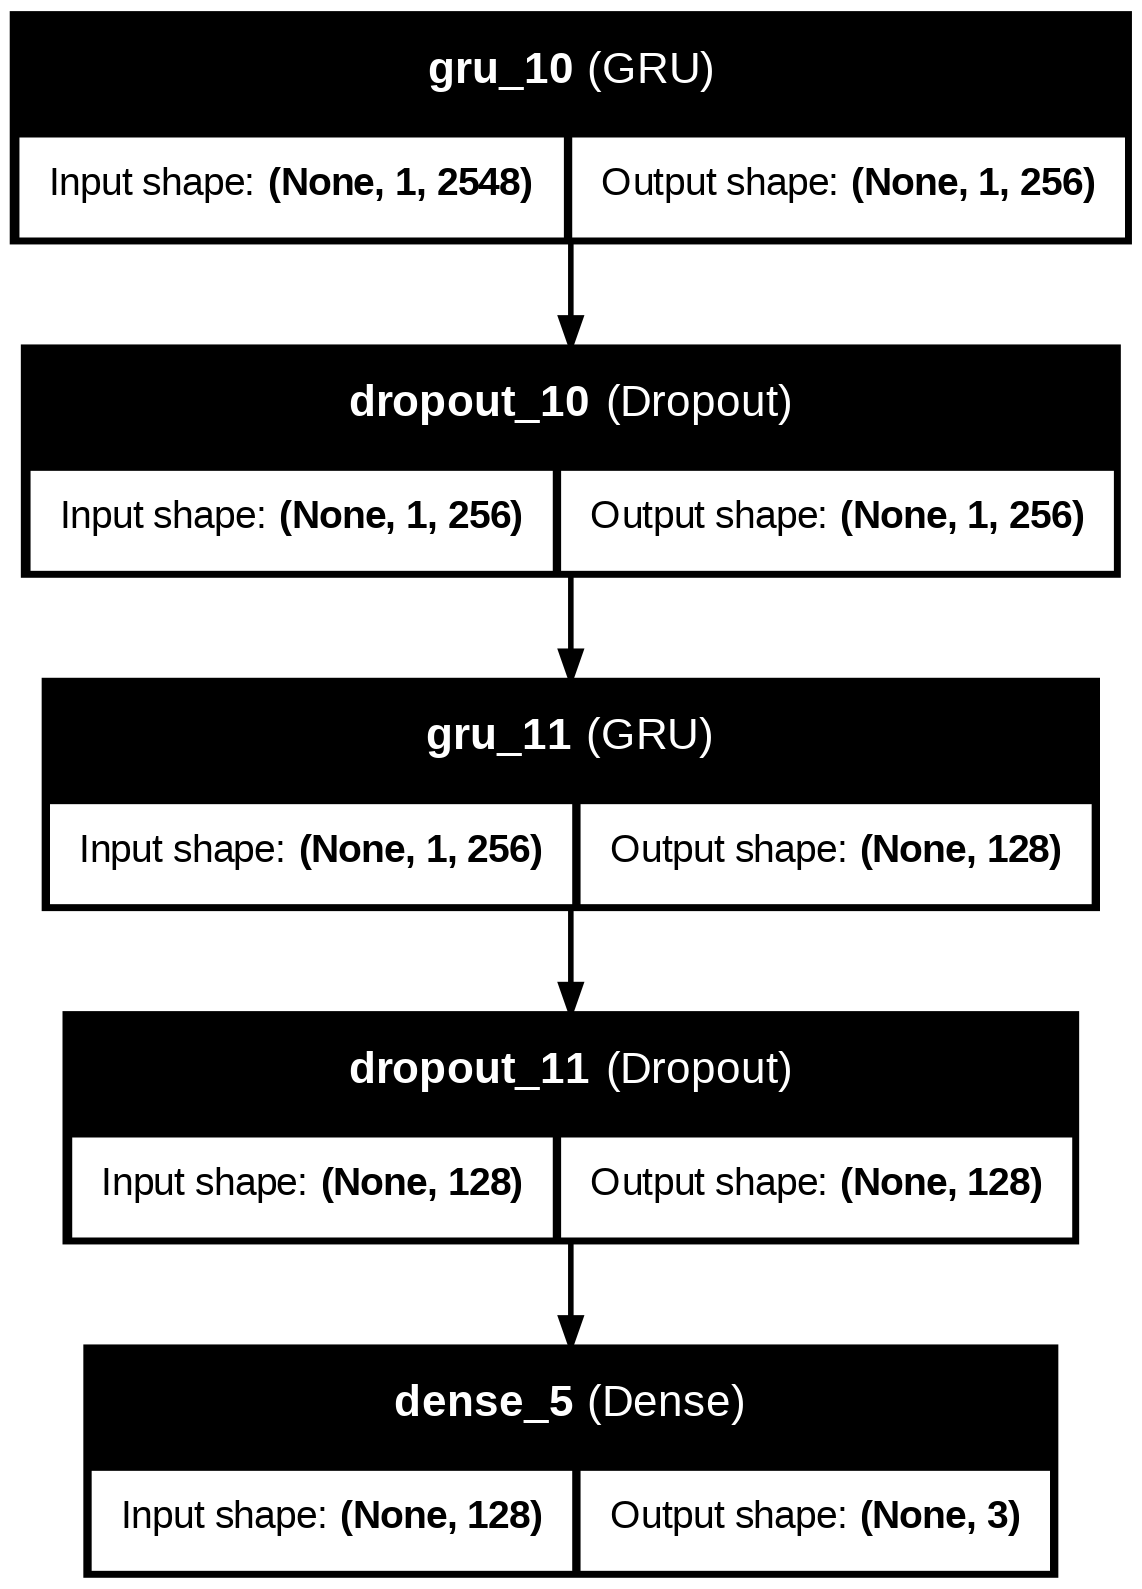

In [ ]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your Keras model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
